#NCRF implementation for Whole Slide Images

#v3 - NCRF method, 3x3 patch, needs to be tuned (epochs, etc...)
Uses the GPU!

References:
M. T. T. Teichmann and R. Cipolla. Convolutional CRFs for
semantic segmentation. *arXiv:1805.04777*, 2018.

Yi Li and Wei Ping. Cancer Metastasis Detection With Neural Conditional Random Field. Medical Imaging with Deep Learning (MIDL), 2018.

- https://github.com/baidu-research/NCRF

In this model, we try to implement a variation of CRFs for pixel labeling, but applied to patches.
---



###Links to reference


1.   https://arxiv.org/pdf/1805.04777.pdf 
2.   https://www.robots.ox.ac.uk/~szheng/papers/CRFasRNN.pdf
3.   



##Setup Code

In [23]:
##Global things that our code will need
import glob
#root_path = "/content/drive/My Drive/STA221_ProjectFinal/"
root_path = "./"
print(glob.glob(root_path+"*")) #Just checking what is in this directory

##Change this to the path with images
image_path = root_path + "NA4077-02_AB-20200523T201212Z-003"


['./Checkpoints', './NA4077-02_AB-20200523T201212Z-003.zip', './NA4077-02_AB-20200523T201212Z-003', './imgTFv1.tfcache.data-00000-of-00001', './CRF_RNN_v1.ipynb', './imgTFv1.tfcache.index', './NCRF_RNN_v3.ipynb', './CRF_RNN_v2.ipynb', './NCRF_RNN_v3_withNeighbourLoss.ipynb']


In [2]:
import os
import sys

import numpy as np
import imageio
import argparse
import logging
import time

# from tensorflow import keras
import matplotlib.pyplot as plt
import json


import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.optim import SGD, Adam
# from tensorboardX import SummaryWriter

%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as Dataset
from skimage import io
import torchvision
from torchvision import datasets, models, transforms

In [4]:

import IPython.display as display
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import pathlib


In [5]:
!nvidia-smi

Thu May 28 19:20:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:65:00.0 Off |                  N/A |
| 20%   32C    P0    57W / 250W |      0MiB / 12194MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

##Preprocessing the Data

In [28]:
#img_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
#images, labels = next(img_gen.flow_from_directory(image_path))
data_dir = pathlib.Path(image_path)
print(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
print(data_dir.name)

NA4077-02_AB-20200523T201212Z-003
156
NA4077-02_AB-20200523T201212Z-003


In [29]:
imageList = list(data_dir.glob('*/*.png'))
print(imageList[0].stem)
print(data_dir)

23040_44800_1111111111111111111111111
NA4077-02_AB-20200523T201212Z-003


In [6]:
BATCH_SIZE = 8
PATCH_SIZE = 3 #Let's start with 3, later we'll try 5

##Patches are 256x256
IMG_HEIGHT = PATCH_SIZE*256
IMG_WIDTH  = PATCH_SIZE*256

CLASS_NAMES_STR = np.array(['bg', 'wm', 'gm'])
CLASS_NAMES  = np.array([0, 1, 2])


In [7]:
def imgLabelToClassLabel(thisLabel): #Either 1, 2, or 4
        label = 0
        if int(thisLabel) == int(2): ##gray matter 
            label = int(2)
        if int(thisLabel) == int(4): ##white matter
            label = int(1)
        if int(thisLabel) == int(1): ##background!
            label = int(0)
        return label

In [32]:
##Defines a Torch Dataset class that describes the dataset    
    
class PatchedNeighbourDataset(Dataset):
  # Inputs:
  # path - string containing path to a directroy of brain dataset image
  # transform - a transform to be done on the image; defaults to none if
  # no transforms are needed
    def __init__(self,path,transform = None):
        data_dir = pathlib.Path(image_path)

        self.path = path
        self.transform = transform
        self.imageList = list(data_dir.glob('*/*.png'))
        self._patch_per_side = 3
        self._grid_size = self._patch_per_side * self._patch_per_side
        self._patch_size = 256
        self._crop_size = 224
    
    

  # Retrieves image at specified index and returns the image along with a label
  # Inputs: 
  # idx - specified image index
  # Outputs:
  # sample - structures containing images and their corresponding labels
    def __getitem__(self,idx):
        img_fullpath = self.imageList[idx]
        
        #print("img_fullpath is", img_fullpath)
        
        img_name = img_fullpath.stem
        image = Image.open(img_fullpath)

        # Add label
        x, y, labels = img_name.split('_')
        labels = list(map(int, list(labels)))
        #print(img_name, labels)
        labels = list(map(imgLabelToClassLabel, labels))
        #print(labels)

        neighbours = np.array([labels[6],  labels[7],  labels[8],
                      labels[11], labels[12], labels[13],
                      labels[16], labels[17], labels[18]])
        
        ###print("old neigh", neighbours)
        #new_neigh = np.zeros((9, 3))
        
        #for i, neigh in enumerate(neighbours):
        #    new_neigh[i] = (np.equal([neigh, neigh, neigh], CLASS_NAMES))
            #print(new_neigh[i])
            
        #neighbours = new_neigh
        ###print("new neighbours shape and val", neighbours.shape, neighbours)
        
        label = labels[12]

        #print("Retrieved x, y, labels", x, y, labels)
        #print("length of labels", len(labels)) ##should be 25

        #Crop to 3x3 grid
        w, h = image.size
        image = image.crop((256, 256, 1024, 1024))
        
        if self.transform:
            image = self.transform(image)
            image = np.array(image, dtype=np.float32).transpose((0, 1, 2))
            
            #flatten it -- maybe change crop_size back to 256?
            img_flat = np.zeros(
            (self._grid_size, 3, self._crop_size, self._crop_size),
            dtype=np.float32)
            
            ###This part is from the NCRF code
            idx = 0
            for x_idx in range(self._patch_per_side):
                for y_idx in range(self._patch_per_side):
                    # center crop each patch
                    x_start = int(
                        (x_idx + 0.5) * self._patch_size - self._crop_size / 2)
                    x_end = x_start + self._crop_size
                    y_start = int(
                        (y_idx + 0.5) * self._patch_size - self._crop_size / 2)
                    y_end = y_start + self._crop_size
                    img_flat[idx] = image[:, x_start:x_end, y_start:y_end]

                    idx += 1
            image = img_flat
            #print("Image is now", image.shape)

        #print("thisLabel is ", label, labels[12])
        sample = {'image':image, 'label':label, 
                  'coords': (x,y), 'neighbours':neighbours}
        #print(label)
        #print(sample)
        
        return sample
  
  # Return the number of images in the dataset
    def __len__(self):
        return len(self.imageList)
  
  # Plot and visualize an image and its corresponding label
  # Copied from Jeff Li's BrainDataSet visualize function
    def visualize(self,idx):
        img_fullpath = self.imageList[idx]
        image = io.imread(img_fullpath)
        img_name = img_fullpath.stem
        print('Full Path:',img_fullpath)
        print('Image Name:',img_name)

        plt.imshow(image)
        plt.show

Full Path: NA4077-02_AB-20200523T201212Z-003/NA4077-02_AB/19200_17920_2222222222222222222222222.png
Image Name: 19200_17920_2222222222222222222222222
156 125 31


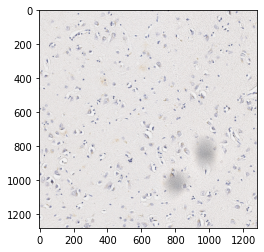

In [33]:
brain = PatchedNeighbourDataset(image_path)
brain.visualize(32)
sample1 = brain.__getitem__(1)
#print(type(sample1['label']))
# Define Parameters
SIZE = brain.__len__()
VAL_RATIO = 0.2
VAL_SIZE = int(SIZE * VAL_RATIO)
TRAIN_SIZE = SIZE - VAL_SIZE
print(SIZE, TRAIN_SIZE, VAL_SIZE) 

In [34]:
## Copied from Jeff Li's baseline training code
##TODO - Jeff to add normalization when running on servers?
def Load_Train_Val(PATH_DIR, TRAIN_SIZE, VAL_SIZE, batch_size):
    # PATH = '/content/drive/My Drive/brain training/training_dataset'
    Train_Dataset = PatchedNeighbourDataset(PATH_DIR,
    #                             train = True,
                              transform = transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(180),
                              transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
                              transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
                              transforms.ToTensor()
                              #,
                              #transforms.Normalize(norm['mean'], norm['std'])
                              ]))
    #   train_data, val_data = torch.utils.data.dataset.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    train_data, val_data = torch.utils.data.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    print('The size of train data: ', len(train_data))
    print('The size of val data: ', len(val_data))
    #   print(len(train_data))
    train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size = batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size = batch_size, shuffle=True)
    return train_loader, val_loader

In [35]:
train_loader, val_loader = Load_Train_Val(image_path, TRAIN_SIZE, VAL_SIZE, batch_size = BATCH_SIZE)
#print(train_loader)
#print(val_loader)

The size of train data:  125
The size of val data:  31


##NCRF Layer, modified from https://github.com/baidu-research/NCRF 

In [36]:
import torch
from torch import nn
### comments starting with "###" are my (Toluwa's) notes

class CRF(nn.Module):
    def __init__(self, num_nodes, iteration=10):
        """Initialize the CRF module
        Args:
            num_nodes: int, number of nodes/patches within the fully CRF
            iteration: int, number of mean field iterations, e.g. 10
        """
        super(CRF, self).__init__()
        self.num_nodes = num_nodes
        self.iteration = iteration
        self.W = nn.Parameter(torch.zeros(1, num_nodes, num_nodes))

    def forward(self, feats, logits):
        """Performing the CRF. Algorithm details is explained below:
        Within the paper, I formulate the CRF distribution using negative
        energy and cost, e.g. cosine distance, to derive pairwise potentials
        following the convention in energy based models. But for implementation
        simplicity, I use reward, e.g. cosine similarity to derive pairwise
        potentials. So now, pairwise potentials would encourage high reward for
        assigning (y_i, y_j) with the same label if (x_i, x_j) are similar, as
        measured by cosine similarity, pairwise_sim. For
        pairwise_potential_E = torch.sum(
            probs * pairwise_potential - (1 - probs) * pairwise_potential,
            dim=2, keepdim=True
        )
        This is taking the expectation of pairwise potentials using the current
        marginal distribution of each patch being tumor, i.e. probs. There are
        four cases to consider when taking the expectation between (i, j):
        1. i=T,j=T; 2. i=N,j=T; 3. i=T,j=N; 4. i=N,j=N
        probs is the marginal distribution of each i being tumor, therefore
        logits > 0 means tumor and logits < 0 means normal. Given this, the
        full expectation equation should be:
        [probs * +pairwise_potential] + [(1 - probs) * +pairwise_potential] +
                    case 1                            case 2
        [probs * -pairwise_potential] + [(1 - probs) * -pairwise_potential]
                    case 3                            case 4
        positive sign rewards logits to be more tumor and negative sign rewards
        logits to be more normal. But because of label compatibility, i.e. the
        indicator function within equation 3 in the paper, case 2 and case 3
        are dropped, which ends up being:
        probs * pairwise_potential - (1 - probs) * pairwise_potential
        In high level speaking, if (i, j) embedding are different, then
        pairwise_potential, as computed as cosine similarity, would approach 0,
        which then as no affect anyway. if (i, j) embedding are similar, then
        pairwise_potential would be a positive reward. In this case,
        if probs -> 1, then pairwise_potential promotes tumor probability;
        if probs -> 0, then -pairwise_potential promotes normal probability.
        Args:
            feats: 3D tensor with the shape of
            [batch_size, num_nodes, embedding_size], where num_nodes is the
            number of patches within a grid, e.g. 9 for a 3x3 grid;
            embedding_size is the size of extracted feature representation for
            each patch from ResNet, e.g. 512
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor before CRF
        Returns:
            logits: 3D tensor with shape of [batch_size, num_nodes, 1], the
            logit of each patch within the grid being tumor after CRF
        """
        ###We can formulate the above as 0 for bg
        ###0.5 for white matter, 1 for grey matter
        ###p=2 means nuclear norm
        #print("input logits are with shape", logits, logits.shape)
        feats_norm = torch.norm(feats, p=2, dim=2, keepdim=True)
        pairwise_norm = torch.bmm(feats_norm,
                                  torch.transpose(feats_norm, 1, 2))
        pairwise_dot = torch.bmm(feats, torch.transpose(feats, 1, 2))
        # cosine similarity between feats
        pairwise_sim = pairwise_dot / pairwise_norm
        # symmetric constraint for CRF weights
        W_sym = (self.W + torch.transpose(self.W, 1, 2)) / 2
        pairwise_potential = pairwise_sim * W_sym
        unary_potential = logits.clone()

        for i in range(self.iteration):
            # current Q after normalizing the logits
            ###probs = torch.transpose(logits.sigmoid(), 1, 2)
            #print("logits before", logits.shape, pairwise_potential.shape)
            probs = torch.transpose(logits.softmax(2, torch.float32), 1, 2)
            #print("logits now", probs, probs.shape, pairwise_potential.shape)
            
            # taking expectation of pairwise_potential using current Q
            ###Toluwa - this may need updating because original was formulated assuming there were only 2 classes
            
            ##Probability that it belongs to class 0
            pairwise_potential_E0 = torch.sum(
                probs[:,0:1,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
                dim=2, keepdim=True)
            
            ##Probability that it belongs to class 1
            pairwise_potential_E1 = torch.sum(
            probs[:,1:2,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
            dim=2, keepdim=True)
            
            ##Probability that it belongs to class 2          
            pairwise_potential_E2 = torch.sum(
            probs[:,2:,:] * pairwise_potential - (1 - probs[:,0:1,:]) * pairwise_potential,
            dim=2, keepdim=True)
            
            pairwise_potential_E = torch.cat((pairwise_potential_E0, pairwise_potential_E1), 2)
            pairwise_potential_E = torch.cat((pairwise_potential_E, pairwise_potential_E2), 2)
            
            #print("unary potential has shape", unary_potential.shape, pairwise_potential_E.shape)
            logits = unary_potential + pairwise_potential_E

        #print("Logits shape is", logits.shape, logits)
        return logits

    def __repr__(self):
        return 'CRF(num_nodes={}, iteration={})'.format(
            self.num_nodes, self.iteration
        )

In [37]:
###Also taken from: https://github.com/baidu-research/NCRF 
### comments starting with "###" are my (Toluwa's) notes

##Resnet definitions
import torch
import torch.nn as nn
import math

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3, num_nodes=1,
                 use_crf=True):
        """Constructs a ResNet model.
        Args:
            num_classes: int, since we are doing binary classification
                (tumor vs normal), num_classes is set to 1 and sigmoid instead
                of softmax is used later
            num_nodes: int, number of nodes/patches within the fully CRF
            use_crf: bool, use the CRF component or not
        """
        ###Jokes, we're NOT doing binary classification so modify this for multi-classification
        ###Mainly we're doing softmax and setting num_classes to 3

        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #print("Model debug block", block, block.expansion)
        self.crf = CRF(num_nodes) if use_crf else None

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x: 5D tensor with shape of
            [batch_size, grid_size, 3, crop_size, crop_size],
            where grid_size is the number of patches within a grid (e.g. 9 for
            a 3x3 grid); crop_size is 224 by default for ResNet input;
        Returns:
            logits, 2D tensor with shape of [batch_size, grid_size], the logit
            of each patch within the grid being tumor
        """
        #print("X shape is", x.shape)
        batch_size, grid_size, _, crop_size = x.shape[0:4]
        # flatten grid_size dimension and combine it into batch dimension
        x = x.view(-1, 3, crop_size, crop_size)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # feats means features, i.e. patch embeddings from ResNet
        feats = x.view(x.size(0), -1)
        #print("feats shape", feats.shape, feats[0].shape)
        #print("feats are", feats)

        logits = self.fc(feats)

        # restore grid_size dimension for CRF
        feats = feats.view((batch_size, grid_size, -1))
        logits = logits.view((batch_size, grid_size, -1))

        if self.crf:
            logits = self.crf(feats, logits)
            
        #print("Final logits shape before squeezeis ", logits.shape, logits)

        logits = torch.squeeze(logits)
        ##Toluwa adding this to return which class we're picking
        ##print("Final logits shape is ", logits.shape, logits)
        #_, logits = torch.max(logits, 2)
        #print("Final logits shape 2 is", logits.shape, logits)
        return logits


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

    return model


def resnet152(**kwargs):
    """Constructs a ResNet-152 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)

    return model

In [38]:
MODELS = {'resnet18': resnet18,
          'resnet34': resnet34,
          'resnet50': resnet50,
          'resnet101': resnet101,
          'resnet152': resnet152}

##Implementing our Model

###Debugging the Model


## Training Time!

In [39]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [44]:
def patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number):
    model.train()
    tcorrect = 0
    ttotal = 0
    ###print("Just got into patched_crf\n\n")
    for epoch in range(num_epochs):
        print("Epoch %d/%d" % (epoch, num_epochs))
        start = time.time()
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            inputs = data['image']
            labels = data['label']
            neighbours = data['neighbours']

            ###print("input shape is", inputs.shape, "neighbour shape is", neighbours.shape)

            ###print("neighbours are",labels, "and", neighbours, "\n")
            ###print("Types are", type(inputs), type(labels), labels.dtype, type(neighbours))
            inputs, labels = Variable(inputs), Variable(labels)
            neighbours = Variable(neighbours)
            inputs = inputs.cuda()
            neighbours = neighbours.cuda()


            ###initialize gradients to zero - https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            optimizer.zero_grad()

            outputs = model(inputs)
            #print("Final output shapes", outputs.shape, neighbours.shape)
            current_p = outputs[:, 4, :]
            outputs = outputs.permute(0, 2, 1)
            
            loss = loss_func(outputs, neighbours)

            ###Backwards propagation
            loss.backward()
            optimizer.step()
            running_loss += float(loss.item())

            
            ###Print status
            if i % 400 == 399:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
                
            _, current_p = torch.max(current_p.data, 1)

            ttotal += neighbours.size(0)
            tcorrect += (neighbours[:,4] == current_p).sum().item()
 
        print('\tAccuracy = %.6f' % (100 * tcorrect / ttotal))

        end = time.time()
        print("Train Time:", end-start)
        print("Traing finished", epoch+1, "epochs")

        model_name = 'PatchedCRF_3x3_'
        MODEL_NAME_1 = model_name + str(number) + '.pkl'
        MODEL_PATH_1 = PATH + '/' + model_name + str(number) + '.pkl'
        ###MODEL_NAME_2 = model_name + 'params_' + str(number) + '.pkl'
        ###MODEL_PATH_2 = PATH + '/' + model_name + 'params_' + str(number) + '.pkl'

        #Not working?
        torch.save(model, MODEL_PATH_1)
        ###torch.save(model.state_dict(), MODEL_PATH_2)
        number = number + 1

    ###get some stats on the values
    correct = 0
    total = 0
    val_loss = 0.0
    window = 2
    model.eval()
    start = time.time()
    
    for i_val, data_val in enumerate(val_loader,0):
        img_val = data_val['image']
        label_val = data_val['label']
        neigh_val = data_val['neighbours']
        
        
        #print("Image shape is", img_val.shape)
        
        img_val, label_val = Variable(img_val), Variable(label_val)
        neigh_val = Variable(neigh_val)
        img_val = img_val.cuda()
        neigh_val = neigh_val.cuda()

        predict = model(img_val)

        predict = predict.permute(0, 2, 1)

        loss_val = loss_func(predict, neigh_val)
        val_loss += loss_val.item()

        ###This is assuming we're using one hot encoding?
        print("predict is of shape", predict.shape)
        print("predict is of value", predict)
        print("\n")
        predict = predict.permute(0, 2, 1)
        predict = predict[:, 4, :]
        print("predict is now", predict)

        _, predict = torch.max(predict.data, 1)
        print("predict is now", predict)
        print("compared to", neigh_val[:,4])
        
        print("neigh val size is", neigh_val.size(0))
        total += neigh_val.size(0)
        correct += (neigh_val[:,4] == predict).sum().item()
        if i_val % window == window-1:    # print every 2000 mini-batches
            print('[%5d] val_loss: %.3f' %
                    (i_val + 1, val_loss / window))
            val_loss = 0.0
    print('Accuracy = %.6f' % (100 * correct / total))
    end = time.time()
    print('val_time', end - start)

    print('Finished Training')
    torch.save(model, MODEL_PATH_1)

In [45]:
cfg = {
 "model": "resnet18",
 "use_crf": True,
 "batch_size": BATCH_SIZE,
 "image_size": IMG_HEIGHT,
 "patch_size": 256,
 "crop_size": 768, ###TODO change this?
 "lr": 0.0001,
 "momentum": 0.9,
 "epoch": 20,
 "log_every": 100
}

###Modified/following https://github.com/baidu-research/NCRF/blob/master/wsi/bin/train.py
if cfg['image_size'] % cfg['patch_size'] != 0:
  raise Exception('Image size / patch size != 0 : {} / {}'.format(cfg['image_size'], cfg['patch_size']))

patch_per_side = cfg['image_size'] // cfg['patch_size']
grid_size = patch_per_side * patch_per_side
model = MODELS[cfg['model']](num_nodes=grid_size, use_crf=cfg['use_crf'])
#model = DataParallel(model, device_ids=None)
model = model.cuda()
print("model is", model)
###we can't use BCEwithLogitsLoss since we're not doing binary classification
loss_func = loss_func = nn.CrossEntropyLoss() #BCEWithLogitsLoss().cuda()

###Maybe try adam later?
optimizer = SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])

model is ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [46]:
#model = torch.load('/BrainSeg/Checkpoints/ResNet18_11.pkl')
loss_func = nn.CrossEntropyLoss()
lr_scheduler = cfg['lr']
###optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
num_epochs = 100

PATH = root_path + '/Checkpoints'
if not os.path.exists(PATH):
    os.makedirs(PATH)
if not os.path.exists(PATH+'/summary'):
    os.makedirs(PATH+'/summary')
number = 12


##Save the model for future use


In [47]:
patched_crf_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

Epoch 0/100
	Accuracy = 45.600000
Train Time: 17.312501907348633
Traing finished 1 epochs
Epoch 1/100


/home/toodemuy/miniconda3/envs/221/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/toodemuy/miniconda3/envs/221/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/toodemuy/miniconda3/envs/221/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type CRF. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


	Accuracy = 48.800000
Train Time: 17.13884449005127
Traing finished 2 epochs
Epoch 2/100
	Accuracy = 56.000000
Train Time: 16.965131521224976
Traing finished 3 epochs
Epoch 3/100
	Accuracy = 60.200000
Train Time: 16.95220971107483
Traing finished 4 epochs
Epoch 4/100
	Accuracy = 62.720000
Train Time: 16.910794734954834
Traing finished 5 epochs
Epoch 5/100
	Accuracy = 64.133333
Train Time: 16.990915775299072
Traing finished 6 epochs
Epoch 6/100
	Accuracy = 65.942857
Train Time: 17.022905826568604
Traing finished 7 epochs
Epoch 7/100
	Accuracy = 66.300000
Train Time: 17.186631679534912
Traing finished 8 epochs
Epoch 8/100
	Accuracy = 67.288889
Train Time: 17.074756145477295
Traing finished 9 epochs
Epoch 9/100
	Accuracy = 68.080000
Train Time: 17.03385305404663
Traing finished 10 epochs
Epoch 10/100
	Accuracy = 69.454545
Train Time: 17.027754068374634
Traing finished 11 epochs
Epoch 11/100
	Accuracy = 69.866667
Train Time: 16.919745445251465
Traing finished 12 epochs
Epoch 12/100
	Accura

	Accuracy = 83.391304
Train Time: 16.94672465324402
Traing finished 92 epochs
Epoch 92/100
	Accuracy = 83.475269
Train Time: 17.020672082901
Traing finished 93 epochs
Epoch 93/100
	Accuracy = 83.540426
Train Time: 16.97634482383728
Traing finished 94 epochs
Epoch 94/100
	Accuracy = 83.595789
Train Time: 16.99817132949829
Traing finished 95 epochs
Epoch 95/100
	Accuracy = 83.583333
Train Time: 17.20999240875244
Traing finished 96 epochs
Epoch 96/100
	Accuracy = 83.620619
Train Time: 16.994012594223022
Traing finished 97 epochs
Epoch 97/100
	Accuracy = 83.640816
Train Time: 17.045934677124023
Traing finished 98 epochs
Epoch 98/100
	Accuracy = 83.692929
Train Time: 16.874337196350098
Traing finished 99 epochs
Epoch 99/100
	Accuracy = 83.784000
Train Time: 17.03852081298828
Traing finished 100 epochs
predict is of shape torch.Size([8, 3, 9])
predict is of value tensor([[[-2.4680, -3.1155, -3.4665, -3.2646, -3.4046, -3.2818, -3.1048,
          -3.6224, -3.5531],
         [ 0.5137,  1.0387, 

predict is of shape torch.Size([7, 3, 9])
predict is of value tensor([[[-1.2963, -1.7450, -1.8053, -2.0030, -1.5461, -2.0523, -0.8316,
          -1.9235, -1.0634],
         [-0.8640, -0.9051, -1.1282, -0.9774, -1.6307, -0.7037, -1.3530,
          -0.9795, -1.0457],
         [ 0.0624,  1.2843,  1.0131,  1.1692,  1.6634,  1.2455, -0.0050,
           1.2468,  0.3307]],

        [[-1.9999, -3.6052, -2.5437, -3.9060, -3.5469, -1.9557, -3.7737,
          -3.5077,  0.1842],
         [ 0.5046,  2.0647,  0.6799,  2.7226,  1.9549,  0.7791,  2.2934,
           1.8422, -1.5769],
         [-0.4694, -0.2648, -0.2843, -0.4215,  0.0112, -0.3378, -0.3919,
          -0.0860, -0.6458]],

        [[-1.6663, -2.2428, -2.0296, -2.1201, -2.2181, -2.3623, -1.5115,
          -2.1979, -2.5000],
         [-0.8208, -0.7803, -1.0952, -1.2899, -0.7699, -0.6159, -0.6453,
          -0.9317, -0.0307],
         [ 0.4580,  1.4866,  1.3528,  1.6809,  1.4484,  1.3747,  0.0995,
           1.3332,  0.6591]],

        [[-2.2

## Validation Time!!

In [ ]:
'''
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
'''